In [1]:
import numpy as np
import torch
from transformers import AlbertTokenizerFast, AlbertModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, EvalPrediction
from datasets import load_dataset, load_metric
from torch.utils.data import Dataset, DataLoader
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset('snli')
#tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
#model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
max_length = 128
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)


Found cached dataset snli (/home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
torch.cuda.is_available()

True

In [4]:
dataset

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [5]:
def compute_accuracy(eval_preds: EvalPrediction):
    return {
        'accuracy': (np.argmax(
            eval_preds.predictions,
            axis=1) == eval_preds.label_ids).astype(
            np.float32).mean().item()
    }

In [6]:
def tokenize_fn(example):
    return tokenizer(example['premise'], example['hypothesis'], truncation=True)
dataset_train = dataset.map(tokenize_fn, batched=True)


Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-91a90241f5f2eee7.arrow


Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-45990820c174b6e6.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-f20f76a3850b7453.arrow


In [7]:
def abs_func(example):
    return {'label': example['label']} if example['label'] >= 0 else {'label':-example['label']}

dataset_train = dataset_train.map(abs_func, batched=False)

Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-60928df63213b5fd.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-411a49af097d03b6.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-cc16e5ba8b5b5932.arrow


In [8]:
np.unique(dataset_train['train']['label'], return_counts=True)

(array([0, 1, 2]), array([183416, 183549, 183187]))

In [9]:
np.unique(dataset_train['validation']['label'], return_counts=True)

(array([0, 1, 2]), array([3329, 3393, 3278]))

In [10]:
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)
model.to('cuda')

#tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
#model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

training_args = TrainingArguments(
	output_dir="output", 
	evaluation_strategy="steps", 
	num_train_epochs = 2,
	warmup_steps = 1000,
	logging_steps = 2000,
	save_steps = 2000,
	load_best_model_at_end = True,
	learning_rate = 5e-5,
    per_device_train_batch_size=64
	)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train['train'],
    eval_dataset=dataset_train['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy

)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
trainer.train()

  0%|          | 0/17194 [00:00<?, ?it/s]

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6501, 'learning_rate': 4.6912436704952454e-05, 'epoch': 0.23}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.42975643277168274, 'eval_accuracy': 0.8379999995231628, 'eval_runtime': 8.6539, 'eval_samples_per_second': 1155.546, 'eval_steps_per_second': 144.443, 'epoch': 0.23}
{'loss': 0.4601, 'learning_rate': 4.073731011485736e-05, 'epoch': 0.47}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.38033682107925415, 'eval_accuracy': 0.8565000295639038, 'eval_runtime': 8.8944, 'eval_samples_per_second': 1124.304, 'eval_steps_per_second': 140.538, 'epoch': 0.47}
{'loss': 0.4197, 'learning_rate': 3.456218352476226e-05, 'epoch': 0.7}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.36044278740882874, 'eval_accuracy': 0.8651000261306763, 'eval_runtime': 8.787, 'eval_samples_per_second': 1138.041, 'eval_steps_per_second': 142.255, 'epoch': 0.7}
{'loss': 0.402, 'learning_rate': 2.838705693466716e-05, 'epoch': 0.93}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3520747423171997, 'eval_accuracy': 0.8690999746322632, 'eval_runtime': 8.6651, 'eval_samples_per_second': 1154.059, 'eval_steps_per_second': 144.257, 'epoch': 0.93}
{'loss': 0.3666, 'learning_rate': 2.2211930344572066e-05, 'epoch': 1.16}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.33750301599502563, 'eval_accuracy': 0.873199999332428, 'eval_runtime': 8.6222, 'eval_samples_per_second': 1159.793, 'eval_steps_per_second': 144.974, 'epoch': 1.16}
{'loss': 0.3499, 'learning_rate': 1.6036803754476966e-05, 'epoch': 1.4}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.33317744731903076, 'eval_accuracy': 0.8797000050544739, 'eval_runtime': 8.758, 'eval_samples_per_second': 1141.818, 'eval_steps_per_second': 142.727, 'epoch': 1.4}
{'loss': 0.3426, 'learning_rate': 9.861677164381871e-06, 'epoch': 1.63}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3272455632686615, 'eval_accuracy': 0.8820000290870667, 'eval_runtime': 8.4423, 'eval_samples_per_second': 1184.511, 'eval_steps_per_second': 148.064, 'epoch': 1.63}
{'loss': 0.3401, 'learning_rate': 3.686550574286773e-06, 'epoch': 1.86}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3198416531085968, 'eval_accuracy': 0.8842999935150146, 'eval_runtime': 9.3541, 'eval_samples_per_second': 1069.054, 'eval_steps_per_second': 133.632, 'epoch': 1.86}
{'train_runtime': 736.3928, 'train_samples_per_second': 1494.181, 'train_steps_per_second': 23.349, 'train_loss': 0.4107755825410572, 'epoch': 2.0}


TrainOutput(global_step=17194, training_loss=0.4107755825410572, metrics={'train_runtime': 736.3928, 'train_samples_per_second': 1494.181, 'train_steps_per_second': 23.349, 'train_loss': 0.4107755825410572, 'epoch': 2.0})

In [12]:
trainer.evaluate(dataset_train['test'])

  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3362944424152374,
 'eval_accuracy': 0.8770999908447266,
 'eval_runtime': 9.0147,
 'eval_samples_per_second': 1109.304,
 'eval_steps_per_second': 138.663,
 'epoch': 2.0}

In [13]:
def str_to_ids(s:str) -> int:
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s))

In [14]:
model.to('cpu')

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [15]:
model(**tokenizer('sample test example', '', return_tensors='pt', truncation=True, padding=True)).logits[0]

tensor([-0.8493,  0.7490, -0.0814], grad_fn=<SelectBackward0>)

In [16]:

def generate_vocab() -> dict:
    p_hat = {}
    for sample in dataset_train['train']:
        words = tokenizer.tokenize(sample['hypothesis'] + sample['premise'])
        
        for w in words:
            if w in p_hat:
                p_hat[w][sample['label']] += 1
            else:
                p_hat[w] = [0, 0, 0]
                p_hat[w][sample['label']] += 1

    return p_hat



In [17]:
p_hat = generate_vocab()

In [18]:
p_hat['wonderful']

[14, 22, 11]

In [19]:
def softmax(a):
    return torch.softmax(torch.tensor(a, dtype=torch.float64), dim=-1)

In [20]:
def prediction(model, word: str, ):
    x1 = model(**tokenizer(word, '', return_tensors='pt', truncation=True, padding=True)).logits[0]
    x1 = [it.item() for it in x1]
    x2 = model(**tokenizer('', word, return_tensors='pt', truncation=True, padding=True)).logits[0]
    x2 = [it.item() for it in x2]
    return (softmax(x1) + softmax(x2))/2

In [21]:
b = p_hat['nobody']
b

[2, 11, 2368]

In [22]:
softmax(p_hat['nobody'])

tensor([0., 0., 1.], dtype=torch.float64)

In [23]:
c = prediction(model, 'nobody')

In [24]:
c

tensor([0.0014, 0.0044, 0.9942], dtype=torch.float64)

In [25]:
def summax(a):
    return a/np.sum(a)

In [26]:
def results(model:AutoModelForSequenceClassification, p_hat: dict):
    df = pd.DataFrame([], columns=['word', 'label', 'prediction'])
    
    for w, values in p_hat.items():
        if np.sum(values) < 20:
            continue
        v = summax(values)
        x = prediction(model, w)
        label = [round(l.item(), 6) for l in v]
        x = [round(i.item(), 6) for i in x]
        df.loc[-1] = [w, values, x]
        df.index += 1
        df = df.sort_index()
            

    return df



In [27]:
analyzed_data = results(model, p_hat)

In [28]:
analyzed_data.head(20)

,word,label,prediction
0,reefs,"[6, 8, 6]","[0.495471, 0.251445, 0.253084]"
1,sovereign,"[8, 9, 9]","[0.694212, 0.209771, 0.096017]"
2,polling,"[7, 8, 7]","[0.120877, 0.110913, 0.76821]"
3,aaron,"[9, 10, 12]","[0.171724, 0.339576, 0.4887]"
4,sb,"[10, 10, 11]","[0.345936, 0.116584, 0.53748]"
5,atrium,"[7, 6, 8]","[0.297901, 0.344686, 0.357413]"
6,fargo,"[9, 8, 8]","[0.054527, 0.166355, 0.779118]"
7,eddie,"[8, 9, 9]","[0.084279, 0.144452, 0.771269]"
8,##nya,"[7, 8, 6]","[0.390862, 0.214216, 0.394922]"
9,##ppa,"[9, 10, 8]","[0.356263, 0.196606, 0.447132]"


In [29]:
p_hat['cats']

[40, 60, 793]

In [30]:
def rejection_fn(n):
    return ((4.74 * np.sqrt(2)) / (3*np.sqrt(n))) + 1/3

In [31]:
contradict = [[],[]]
entail = [[],[]]
neutral = [[],[]]
points = [[],[]]
for i, it in analyzed_data.iterrows():
    pred = np.argmax(it['prediction'])
    ph = it['label'][pred]/np.sum(it['label'])
    s = np.sum(it['label'])
    if rejection_fn(s) < ph:
        if pred == 0:
            entail[1].append(ph)
            entail[0].append(np.sum(it['label']))
        elif pred == 1:
            neutral[1].append(ph)
            neutral[0].append(np.sum(it['label']))
        else:
            contradict[1].append(ph)
            contradict[0].append(np.sum(it['label']))
    else:
        points[1].append(ph)
        points[0].append(np.sum(it['label']))

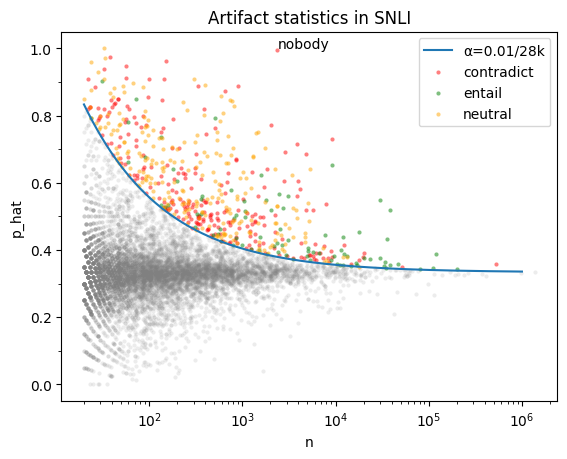

In [32]:
x = np.linspace(20,1e6,1000000)
y = rejection_fn(x)
plt.plot(x,y)
plt.scatter(contradict[0], contradict[1], c='r', alpha=0.5, marker=".", linewidths=0)
plt.scatter(entail[0], entail[1], c='g', alpha=0.5, marker=".", linewidths=0)
plt.scatter(neutral[0], neutral[1], c='orange', alpha=0.5, marker=".", linewidths=0)
plt.xscale('log')
plt.yticks(ticks=np.arange(0, 1.01, step=0.1), minor=True)
plt.title('Artifact statistics in SNLI')
plt.ylabel('p_hat')
plt.xlabel('n')
plt.legend(['α=0.01/28k','contradict', 'entail', 'neutral'])
plt.text(np.sum(p_hat['nobody']), 1-np.argmax(p_hat['nobody'])/np.sum(p_hat['nobody']), 'nobody')
plt.scatter(points[0], points[1], c='grey', alpha=0.15, marker=".", linewidths=0)
plt.show()

In [33]:
k = 100
top_values = [(0,0,0,0) for i in range(k)]
for i, it in analyzed_data.iterrows():
    pred = np.argmax(it['prediction'])
    ph = it['label'][pred]/np.sum(it['label'])
    s = np.sum(it['label'])
    dist = ph - rejection_fn(s)
    if dist > top_values[0][1]:
        values = (it['word'], dist, it['label'], it['prediction'])
        top_values.pop(0)
        for i in range(k-1):
            if dist < top_values[i][1]-rejection_fn(np.sum(top_values[i][2])):
                top_values.insert(i, values)
                break
        if len(top_values) != k:
            top_values.append(values)



/tmp/ipykernel_137197/2018955436.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return ((4.74 * np.sqrt(2)) / (3*np.sqrt(n))) + 1/3


In [34]:
top_values[-20:]

[('gay', 0.18174958362135035, [29, 150, 47], [0.107856, 0.870742, 0.021402]),
 ('boyfriend',
  0.3414249681001805,
  [10, 207, 37],
  [0.377418, 0.530916, 0.091666]),
 ('aliens', 0.35322092381171766, [2, 7, 91], [0.001121, 0.002029, 0.996849]),
 ('prize', 0.20416943788643294, [27, 123, 24], [0.388694, 0.553819, 0.057487]),
 ('won', 0.23887469255719435, [62, 288, 73], [0.33269, 0.621009, 0.046301]),
 ('famous', 0.3554317331142218, [33, 312, 44], [0.285464, 0.698891, 0.015645]),
 ('cat', 0.3468573390378819, [459, 630, 2749], [0.000431, 0.001904, 0.997665]),
 ('bed',
  0.23749138383606933,
  [738, 802, 2374],
  [0.039328, 0.072084, 0.888588]),
 ('favorite', 0.4181598131924143, [36, 681, 104], [0.096, 0.892696, 0.011304]),
 ('hungry',
  0.26031416185071865,
  [42, 226, 46],
  [0.225495, 0.762482, 0.012023]),
 ('married',
  0.21231109783842944,
  [216, 672, 208],
  [0.390074, 0.575474, 0.034452]),
 ('after',
  0.17635839646546653,
  [924, 2759, 1417],
  [0.250248, 0.452642, 0.29711]),
 ('gr

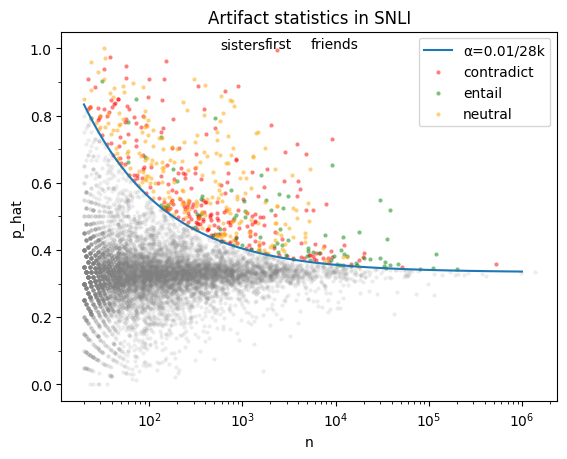

In [35]:
plt.plot(x,y)
plt.scatter(contradict[0], contradict[1], c='r', alpha=0.5, marker=".", linewidths=0)
plt.scatter(entail[0], entail[1], c='g', alpha=0.5, marker=".", linewidths=0)
plt.scatter(neutral[0], neutral[1], c='orange', alpha=0.5, marker=".", linewidths=0)
plt.xscale('log')
plt.yticks(ticks=np.arange(0, 1.01, step=0.1), minor=True)
plt.title('Artifact statistics in SNLI')
plt.ylabel('p_hat')
plt.xlabel('n')
plt.legend(['α=0.01/28k','contradict', 'entail', 'neutral'])
for it in top_values[-3:]:
    plt.text(np.sum(it[2]), 1-np.argmax(it[2])/np.sum(it[2]), it[0])
plt.scatter(points[0], points[1], c='grey', alpha=0.15, marker=".", linewidths=0)
plt.show()

In [36]:
def prediction_model(model, a, b = '', tensor = False):
    x1 = model(**tokenizer(a, b, return_tensors='pt', truncation=True, padding=True)).logits[0]
    if tensor: return torch.softmax(x1, dim=-1)
    return [l.item() for l in torch.softmax(x1, dim=-1)]

prediction_model(model, 'nobody mute weekly nephew aunt', '')


[0.006536610424518585, 0.2845648229122162, 0.7088985443115234]

In [37]:
avg = []
for i in range(100):
    avg.append([])
    for sample in dataset_train['validation']:
        x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
        if top_values[-i][0] in x1:
            avg[i].append(prediction_model(model, sample['premise'], sample['hypothesis']))



In [38]:
avg.pop(0)

[[0.003933468833565712, 0.9771779775619507, 0.01888854056596756]]

In [39]:
likelihood_given = []
for i in range(1,100):
   if len(avg[-i]) == 0:
      continue
   a = np.average(avg[-i], axis=0)
   am = int(np.argmax(top_values[-i][2]))
   likelihood_given.append(a[am])

In [40]:
for i in range(1,100):
    if len(avg[-i]) == 0:
        continue
    print(top_values[-i][0], top_values[-i][2], np.average(avg[-i], axis=0))

friends [758, 3429, 1168] [0.15161497 0.33734881 0.5110362 ]
first [216, 1234, 302] [0.00740638 0.25047468 0.74211897]
winning [43, 657, 78] [0.00831702 0.98626226 0.00542075]
friend [337, 1457, 475] [0.01879804 0.48396555 0.49723643]
no [693, 809, 3296] [2.22708753e-04 3.61287454e-03 9.96164441e-01]
nobody [2, 11, 2368] [0.13556915 0.34392122 0.52050964]
great [174, 376, 169] [0.2983431  0.19737703 0.50427987]
married [216, 672, 208] [0.02030961 0.88497927 0.09471112]
hungry [42, 226, 46] [0.19416988 0.20577576 0.60005436]
favorite [36, 681, 104] [0.00970379 0.62484238 0.36545381]
bed [738, 802, 2374] [0.00543153 0.83693934 0.15762913]
cat [459, 630, 2749] [4.44532896e-04 3.83936746e-03 9.95716115e-01]
famous [33, 312, 44] [0.30371102 0.59740154 0.09888742]
won [62, 288, 73] [0.17112686 0.66744013 0.161433  ]
prize [27, 123, 24] [0.06220347 0.06465465 0.87314186]
aliens [2, 7, 91] [0.04608519 0.56010794 0.39380688]
boyfriend [10, 207, 37] [0.00140987 0.18430324 0.81428689]
gay [29, 15

In [41]:
np.average(likelihood_given)

0.4290699356994906

In [42]:
#training on hard data
artifact_words = [it[0] for it in top_values]
artifact_words  = set(artifact_words)

In [43]:
artifact_acc = 0.
non_artifact_acc = 0.
total_acc = 0.
aa = 0
na = 0
ta = 0

for sample in dataset_train['test']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
    total_acc += result
    ta += 1 
    T = True
    for word in x1:
        if word in artifact_words:
            artifact_acc += result
            aa += 1
            T = False
            break
    if T:
        non_artifact_acc += result
        na += 1

In [44]:
print(total_acc/ta)
print(artifact_acc/aa)
print(non_artifact_acc/na)

0.8771
0.9054945054945055
0.8726114649681529


In [45]:
print(ta)
print(aa)
print(na)

10000
1365
8635


In [46]:
artifact_acc = [0,0,0]
non_artifact_acc = [0,0,0]
total_acc = [0,0,0]
aa = [0,0,0]
na = [0,0,0]
ta = [0,0,0]

for sample in dataset_train['test']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
    total_acc[sample['label']] += result
    ta[sample['label']] += 1 
    T = True
    for word in x1:
        if word in artifact_words:
            artifact_acc[sample['label']] += result
            aa[sample['label']] += 1
            T = False
            break
    if T:
        non_artifact_acc[sample['label']] += result
        na[sample['label']] += 1

In [47]:
for i in range(3):
    print(f'total: {total_acc[i]/ta[i]}\tart: {artifact_acc[i]/aa[i]}\tna: {non_artifact_acc[i]/na[i]}')

total: 0.9008313539192399	art: 0.8506787330316742	na: 0.9043533523991103
total: 0.8176730486008836	art: 0.9070146818923328	na: 0.7979870596693026
total: 0.9147358665430955	art: 0.9265536723163842	na: 0.9124168514412417


In [48]:
for i in range(3):
    print(f'total: {ta[i]}\tart: {aa[i]}\tna: {na[i]}')

total: 3368	art: 221	na: 3147
total: 3395	art: 613	na: 2782
total: 3237	art: 531	na: 2706


In [49]:
#next compare words that are very close to 1/3 for all classes in the dataset
non_artifact_words = []
k = 100
for i, it in analyzed_data.iterrows():
    sm = softmax(it['label'])
    T = True
    for x in sm:
        if x > 0.4 or x < 0.25 or not it['word']:
            T = False
    if T:
        non_artifact_words.append(it['word'])

In [50]:
non_artifact_words

['batsman',
 'inhabit',
 '##sk',
 'curves',
 '##bbled',
 'appeared',
 'defended',
 'amber',
 'confederate',
 'bluff',
 'wwii',
 '09',
 'counters',
 'diploma',
 'sud',
 'adjoining',
 'embedded',
 'grasses',
 'servicing',
 '##qu',
 '##rdan',
 'manor',
 'sloping',
 'describe',
 'northern',
 '##centric',
 'victorian',
 'apparent',
 '##we',
 'descended',
 'wells',
 'bottled',
 '##ify',
 'visitors',
 'pitchers',
 'aviation',
 'festivities',
 'bordering',
 '##bow',
 'bubbling',
 'interrupted',
 'mint',
 'multicultural',
 'presumably',
 'pun',
 'stud',
 'stricken',
 'deter',
 'kurt',
 '##cher',
 'weathered',
 'tudor',
 'wheeling',
 'vial',
 'distorted',
 '##cards',
 '##ible',
 'accompanying',
 'thinner',
 'description',
 '##rai',
 'facade',
 'arching',
 'pedestal',
 'lei',
 'attractions',
 '##tops',
 '##tate',
 'airways',
 'notre',
 'predominantly',
 'tribes',
 'forearm',
 'vaults',
 'buses',
 'parallel',
 '##tone',
 'surgical',
 'flowering',
 'miscellaneous',
 'twenties',
 '##olic']

In [51]:
len(non_artifact_words)

82

In [52]:
artifact_acc = 0.
non_artifact_acc = 0.
total_acc = 0.
aa = 0
na = 0
ta = 0

for sample in dataset_train['test']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
    total_acc += result
    ta += 1 
    T = True
    for word in x1:
        if word in non_artifact_words:
            artifact_acc += result
            aa += 1
            T = False
            break
    if T:
        non_artifact_acc += result
        na += 1

In [53]:
print(total_acc/ta)
print(artifact_acc/aa)
print(non_artifact_acc/na)

0.8771
0.8260869565217391
0.8774544356056792


In [54]:
print(ta)
print(aa)
print(na)

10000
69
9931


In [55]:
score = {}
for word in artifact_words:
    score[word] = []

for sample in dataset_train['train']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    T = True
    for word in x1:
        if word in artifact_words:
            result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
            score[word].append(result)
            break


In [56]:
for x in score:
    print(x, np.average(score[x]), score[x])

hoping 0.8882978723404256 [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
office 0.8988458927359131 [1.0, 0

In [57]:
score = {}
for word in non_artifact_words:
    score[word] = []

for sample in dataset_train['test']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    T = True
    for word in x1:
        if word in non_artifact_words:
            result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
            score[word].append(result)
            break


In [58]:
for x in score:
    print(x, np.average(score[x]), score[x])

batsman 0.6666666666666666 [0.0, 1.0, 1.0]
inhabit nan []
##sk nan []
curves nan []
##bbled 1.0 [1.0, 1.0, 1.0]
appeared nan []
defended nan []
amber nan []
confederate nan []
bluff nan []
wwii nan []
09 nan []
counters nan []
diploma nan []
sud nan []
adjoining nan []
embedded nan []
grasses 1.0 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
servicing nan []
##qu nan []
##rdan nan []
manor nan []
sloping nan []
describe nan []
northern nan []
##centric nan []
victorian 1.0 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
apparent 0.6666666666666666 [0.0, 1.0, 1.0]
##we nan []
descended nan []
wells nan []
bottled 0.6666666666666666 [1.0, 1.0, 0.0]
##ify nan []
visitors nan []
pitchers nan []
aviation nan []
festivities 0.75 [0.0, 1.0, 1.0, 1.0]
bordering nan []
##bow nan []
bubbling nan []
interrupted nan []
mint nan []
multicultural nan []
presumably nan []
pun nan []
stud 1.0 [1.0]
stricken nan []
deter nan []
kurt nan []
##cher nan []
weathered nan []
tudor nan []
wheeling nan []
vial 1.0 [1.0]
distorted nan []
##c

/home/brian/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/brian/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [59]:
artifact_acc = [0,0,0]
non_artifact_acc = [0,0,0]
total_acc = [0,0,0]
aa = [0,0,0]
na = [0,0,0]
ta = [0,0,0]

for sample in dataset_train['test']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
    total_acc[sample['label']] += result
    ta[sample['label']] += 1 
    T = True
    for word in x1:
        if word in non_artifact_words:
            artifact_acc[sample['label']] += result
            aa[sample['label']] += 1
            T = False
            break
    if T:
        non_artifact_acc[sample['label']] += result
        na[sample['label']] += 1

In [60]:
for i in range(3):
    print(f'total: {total_acc[i]/ta[i]}\tart: {artifact_acc[i]/aa[i]}\tna: {non_artifact_acc[i]/na[i]}')

total: 0.9008313539192399	art: 0.7727272727272727	na: 0.9016736401673641
total: 0.8176730486008836	art: 0.7391304347826086	na: 0.8182087781731909
total: 0.9147358665430955	art: 0.9583333333333334	na: 0.9144102085278556


In [61]:
for i in range(3):
    print(f'total: {ta[i]}\tart: {aa[i]}\tna: {na[i]}')

total: 3368	art: 22	na: 3346
total: 3395	art: 23	na: 3372
total: 3237	art: 24	na: 3213


In [62]:
analyzed_data[analyzed_data.word == 'better']

,word,label,prediction
6654,better,"[48, 116, 45]","[0.464789, 0.504919, 0.030291]"


In [63]:
analyzed_data[analyzed_data.word == 'will']

,word,label,prediction
7201,will,"[193, 573, 235]","[0.328471, 0.278768, 0.39276]"


In [64]:
analyzed_data[analyzed_data.word == 'beds']

,word,label,prediction
6248,beds,"[31, 31, 148]","[0.227186, 0.15755, 0.615264]"


In [65]:
for word in artifact_words:
    print(analyzed_data[analyzed_data.word == word])

        word          label                      prediction
6099  hoping  [27, 141, 33]  [0.286141, 0.562732, 0.151127]
        word            label                     prediction
7549  office  [361, 542, 814]  [0.111634, 0.28388, 0.604486]
       word          label                      prediction
8403  prize  [27, 123, 24]  [0.388694, 0.553819, 0.057487]
       word             label                     prediction
7673  owner  [122, 1059, 235]  [0.115513, 0.57805, 0.306436]
         word          label                    prediction
5574  popcorn  [32, 42, 101]  [0.001875, 0.0214, 0.976725]
          word          label                      prediction
5544  siblings  [13, 276, 15]  [0.170489, 0.799782, 0.029728]
         word            label                      prediction
8803  married  [216, 672, 208]  [0.390074, 0.575474, 0.034452]
         word        label                      prediction
5791  zombies  [8, 13, 71]  [0.003195, 0.013198, 0.983607]
        word             label  

In [66]:
max_words = ['better', 'will', 'beds']
alien_acc = [0,0,0]
aa = [0,0,0]
for sample in dataset_train['train']:
    x1 = tokenizer.tokenize(sample['premise']) + tokenizer.tokenize(sample['hypothesis'])
    T = True
    for word in x1:
        if word in max_words:
            result = 1. if torch.argmax(prediction_model(model, sample['premise'], sample['hypothesis'], True)) == sample['label'] else 0.
            alien_acc[sample['label']] += result
            aa[sample['label']] += 1
            if sample['label'] == 0 and result == 0:
                print(result, sample['premise'], sample['hypothesis'])
            break

0.0 Two men are sitting on some scaffolding and painting a wall. The men are making the wall look better.
0.0 There are four individuals standing together in a line at the waters edge wearing black diving gear with red and black flippers. The four individuals will get wet.
0.0 A man chiseling art out of a piece of stone. The man will have to chisel for a long time to finish
0.0 A man wearing a brim hat and white t-shirt is standing behind a wheeled cart. The man will take the cart somewhere else soon.
0.0 A man is standing on a platform looking at a large crane. A man stands up on a platform for a better look at a large crane.
0.0 A young boy is jumping head first from a dock into the water. A young boy will make a splash.
0.0 Boy stands near laundry hanging out to dry. The laundry will dry from the wind and sun.
0.0 A man in a home kitchen is flipping a pancake extremely high. The man will try to catch the pancake.
0.0 Some people are watching a little girl and a owner of a stand maki

In [67]:
print(alien_acc)
print(aa)

[179.0, 637.0, 339.0]
[254, 701, 412]


In [68]:
prediction_model(model, "The food needs to be eaten soon.", "The food will expire fast.")

[0.3466900885105133, 0.33872726559638977, 0.31458261609077454]

In [69]:
prediction_model(model, "A man with a cane walks away from a food cart.", "The cane helps the man walk better.")

[0.3613424003124237, 0.5941683053970337, 0.04448924586176872]

In [70]:
prediction_model(model, "Two men are in a room with four visible beds.", "Two men showing their bedroom to photographer.")

[0.022129228338599205, 0.9607348442077637, 0.0171359833329916]

In [10]:
def create_map_data(model:AutoModelForSequenceClassification, data:pd.DataFrame) -> pd.DataFrame:
    #df = pd.DataFrame([], columns=['premise','hypothesis', 'label','e0', 'e1', 'e2', 'e3', 'e4', 'confidence', 'variability'])
    dict_data = {'premise':[], 'hypothesis':[], 'label':[], 'e0':[], 'e1':[], 'e2':[], 'e3':[], 'e4':[], 'confidence':[], 'variability':[]}
    for sample in tqdm.notebook.tqdm(data['train']):
        dict_data['premise'].append(sample['premise'])
        dict_data['hypothesis'].append(sample['hypothesis'])
        dict_data['label'].append(sample['label'])
        dict_data['e0'].append(0.)
        dict_data['e1'].append(0.)
        dict_data['e2'].append(0.)
        dict_data['e3'].append(0.)
        dict_data['e4'].append(0.)
        dict_data['confidence'].append(0.)
        dict_data['variability'].append(0.)
        #df.loc[-1] = [sample['premise'], sample['hypothesis'], sample['label'], 0., 0., 0., 0., 0., 0., 0.]
        #df.index += 1
        #df = df.sort_index()
            
    df = pd.DataFrame.from_dict(dict_data)
    return df

In [11]:
def train_model(model, tokenizer, dataset_train, epochs = 1):

    #tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
    #model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

    training_args = TrainingArguments(
        output_dir="output", 
        evaluation_strategy="steps", 
        num_train_epochs = epochs,
        warmup_steps = 1000,
        logging_steps = 2000,
        save_steps = 2000,
        load_best_model_at_end = True,
        learning_rate = 5e-5,
        per_device_train_batch_size=64
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_train['train'],
        eval_dataset=dataset_train['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_accuracy

    )
    trainer.train()

In [12]:
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)
model.to('cuda')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [13]:
map_data = create_map_data(model, dataset_train)
map_data

  0%|          | 0/550152 [00:00<?, ?it/s]

,premise,hypothesis,label,e0,e1,e2,e3,e4,confidence,variability
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Children smiling and waving at camera,They are smiling at their parents,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Children smiling and waving at camera,There are children present,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
550147,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550148,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550149,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550150,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
for e in range(5):
    train_model(model, tokenizer, dataset_train)
    
    for i, sample in tqdm.notebook.tqdm(map_data.iterrows()):

        x = model(**tokenizer(sample['premise'], sample['hypothesis'], return_tensors='pt', truncation=True, padding=True).to('cuda')).logits[0][sample['label']]
        sample['e'+str(e)] = x.to('cpu')


  0%|          | 0/8597 [00:00<?, ?it/s]

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 9.75 GiB total capacity; 8.93 GiB already allocated; 52.12 MiB free; 8.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
"""
@inproceedings{swayamdipta2020dataset,
    title={Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics},
    author={Swabha Swayamdipta and Roy Schwartz and Nicholas Lourie and Yizhong Wang and Hannaneh Hajishirzi and Noah A. Smith and Yejin Choi},
    booktitle={Proceedings of EMNLP},
    url={https://arxiv.org/abs/2009.10795},
    year={2020}
}
"""

def scatter_it(dataframe, hue_metric ='correct.', title='', model = 'electra', show_hist=False):
    import seaborn as sns
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()
    filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)


In [ ]:
def create_map(dataset: pd.DataFrame, model = 'electra'):
    model = None
    if model == 'electra':
        tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)
        model.to('cuda')
    elif model == 'albert':
        tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2', use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
    else:
        raise Exception('Invalid model choice')
    
    mapped_data = create_map_data(model, dataset)

    for e in range(5):
        train_model(model, tokenizer, dataset_train)
        
        for sample in mapped_data.iterrows():
            x = model(**tokenizer(sample['premise'], sample['hypothesis'], return_tensors='pt', truncation=True, padding=True)).logits[0]
            sample['e'+str(e)] = x

    for sample in tqdm.notebook.tqdm(mapped_data.iterrows()):
        sample['confidence'] = np.average([sample['e'+str(e)] for e in range(5)])
        sample['variability'] = np.sqrt(np.average([(sample['e'+str(e)] - sample['confidence'])**2]))

    scatter_it(mapped_data)

    

In [ ]:
create_map(dataset_train)